## Dog vs Cat - 基於VGG16的transfer learning

利用Kaggle的Dogs vs Cats做VGG16的transfer learning 的學習

In [1]:
import os

ROOT_DIR = os.getcwd()
DATA_PATH = os.path.join(ROOT_DIR, "dogs-vs-cats")
SOURCE_DATA_DIR = os.path.join(DATA_PATH, "train")

print('length of train data %d' %(len(os.listdir(TRAIN_DIR))))

In [2]:
BASE_DIR = os.path.join(DATA_PATH, "VGG_Practice")
if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
    
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
    
TEST_DIR = os.path.join(BASE_DIR, "TEST")
if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)
    
DOG_TRAIN = os.path.join(TRAIN_DIR, "DOG")
if not os.path.exists(DOG_TRAIN):
    os.mkdir(DOG_TRAIN)

CAT_TRAIN = os.path.join(TRAIN_DIR, "CAT")
if not os.path.exists(CAT_TRAIN):
    os.mkdir(CAT_TRAIN)
    
DOG_TEST = os.path.join(TEST_DIR, "DOG")
if not os.path.exists(DOG_TEST):
    os.mkdir(DOG_TEST)
    
CAT_TEST = os.path.join(TEST_DIR, "CAT")
if not os.path.exists(CAT_TEST):
    os.mkdir(CAT_TEST)


In [3]:
import shutil

for frame in ['cat.{}.jpg'.format(i) for i in range(0,2000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(0,2000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['cat.{}.jpg'.format(i) for i in range(10001,12000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['dog.{}.jpg'.format(i) for i in range(10001,12000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

train_datagen = train_gen.flow_from_directory(
            TRAIN_DIR,
            target_size=(224,224),
            batch_size=20,
            classes=['dog','cat'],
            subset='training'
            )

validation_datagen = train_gen.flow_from_directory(
            TRAIN_DIR,
            target_size=(224,224),
            batch_size=20,
            classes=['dog','cat'],
            subset='validation'
            )

test_datagen = test_gen.flow_from_directory(
            TEST_DIR,
            target_size=(224,224),
            batch_size=20,
            classes=['dog','cat'],
            )

for train_batch, label_batch in train_datagen:
    print('train_batch_shape: ', train_batch.shape)
    print('label_batch_shape: ', label_batch.shape)
    break;

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
train_batch_shape:  (20, 224, 224, 3)
label_batch_shape:  (20, 2)


In [6]:
from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [7]:
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential

model = Sequential()

model.add(vgg_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(2,activation = 'softmax'))

for layer in model.layers[:2]:
    layer.trainable=False
    
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                250890    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 22        
Total params: 14,965,710
Tr

In [29]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

train_history = model.fit_generator(train_datagen,
                                    steps_per_epoch=20,
                                    epochs=30,
                                    validation_data=validation_datagen,
                                    validation_steps=10,
                                    verbose=1)

Epoch 1/30
20/20 [==============================] - 5s 247ms/step - loss: 0.7010 - acc: 0.5550 - val_loss: 0.6685 - val_acc: 0.4867
Epoch 2/30
20/20 [==============================] - 4s 202ms/step - loss: 0.6057 - acc: 0.6010 - val_loss: 0.5060 - val_acc: 0.7621
Epoch 3/30
20/20 [==============================] - 4s 205ms/step - loss: 0.4132 - acc: 0.8400 - val_loss: 0.3357 - val_acc: 0.9000
Epoch 4/30
20/20 [==============================] - 4s 209ms/step - loss: 0.3442 - acc: 0.8400 - val_loss: 0.2450 - val_acc: 0.9133
Epoch 5/30
20/20 [==============================] - 4s 205ms/step - loss: 0.3129 - acc: 0.8700 - val_loss: 0.2213 - val_acc: 0.9207
Epoch 6/30
20/20 [==============================] - 4s 207ms/step - loss: 0.2816 - acc: 0.8833 - val_loss: 0.2470 - val_acc: 0.9000
Epoch 7/30
20/20 [==============================] - 4s 205ms/step - loss: 0.2291 - acc: 0.9075 - val_loss: 0.2183 - val_acc: 0.9069
Epoch 8/30
20/20 [==============================] - 4s 208ms/step - loss: 0.

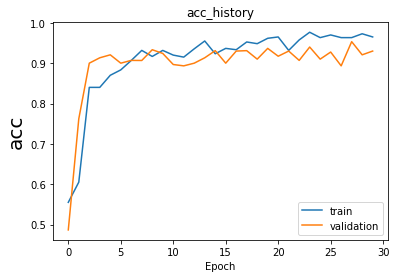

In [30]:
import matplotlib.pyplot as plt

def plot_train_result(train_history,train,val):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.legend(['train','validation'])
    plt.title(train+'_history')
    plt.xlabel('Epoch')
    plt.ylabel(train,fontsize=20)
    plt.show()
    
plot_train_result(train_history,'acc','val_acc')

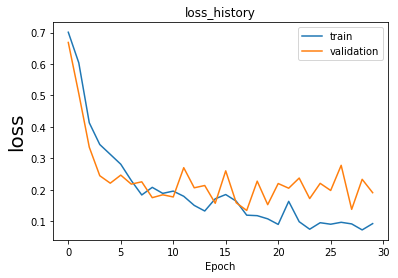

In [31]:
plot_train_result(train_history,'loss','val_loss')

In [34]:
scores = model.evaluate_generator(test_datagen,steps= 10)
print('test data accuracy: %.2f' %(scores[1]*100))

test data accuracy: 90.50


In [ ]:
model.save('dog-vs-cat-vgg16.h5')